# Data Visualization and Tools

In machine learning it's crucial to start by understanding our data. This project uses a dataset with 2-dimensional feature vectors, which we can effectively visualize using a scatter plot. This visualization helps us quickly identify patterns and anomalies, guiding our choice of methods for the problem. It's a practical step to assess how our data behaves before diving into more complex analyses.

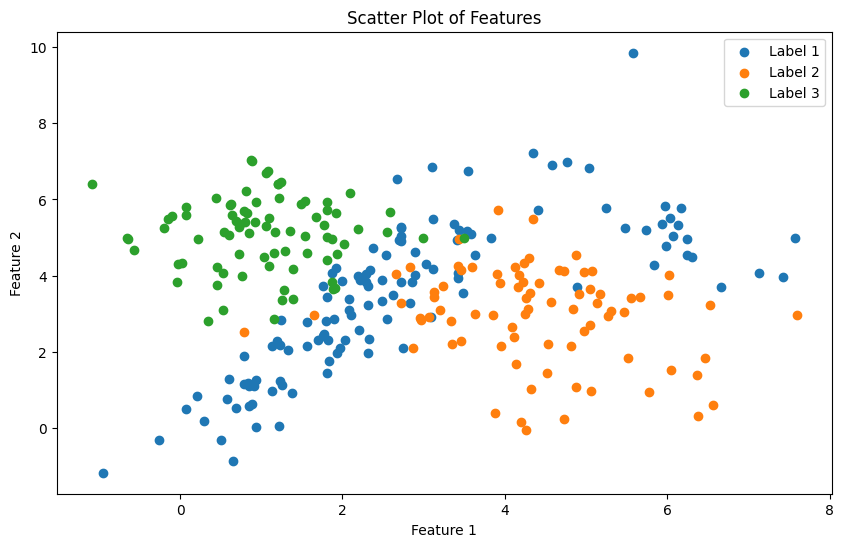

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import numpy as np

file_path = 'dataset.csv'

data = np.loadtxt("dataset.csv", delimiter=",", dtype=np.float64)
features = data[:,:-1]
labels = data[:,-1]

plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    subset = features[labels == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=f'Label {int(label)}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Features')
plt.legend()
plt.show()



Although we can tell from the diagram that different classes seem fairly balanced it is always good practice to calculate the relative percentages. If there were heavy imbalances we must be cautious to calculate more metrics such as recall, precision, f1-score since relying on accuracy can lead to classifiers that are not adept at discerning different classes

In [ ]:
# Calculate the unique class labels and their counts
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Calculate the total number of samples
total_samples = len(labels)

# Calculate the percentages for each class
class_percentages = class_counts / total_samples * 100

# Print the relevant percentages for each class
for class_label, percentage in zip(unique_classes, class_percentages):
    print(f"Class {int(class_label)}: {percentage:.2f}%")

Class 1: 42.86%
Class 2: 28.57%
Class 3: 28.57%


A key technique we'll employ for the initial three plots is the visualization of classifier regions. To achieve this, we've developed a function specifically designed for 2-dimensional data. This function classifies a grid of points spanning a broad area of the feature space. By doing so, it creates distinct regions corresponding to each class.

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier, resolution=0.02):
    """
    Visualizes decision boundaries for classifiers using training and testing data.

    Parameters
    ----------
    X_train : array-like, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
    X_test : array-like, shape = [n_samples, n_features]
        Testing vectors, similar in structure to X_train.
    y_train : array-like, shape = [n_samples]
        Target values for training samples.
    y_test : array-like, shape = [n_samples]
        Target values for testing samples.
    classifier : object
        A fitted classifier object with a predict method.
    resolution : float, optional
        The resolution of the grid for plotting the decision surface, by default 0.02.

    Returns
    -------
    None.

    Example
    -------
    >> plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier)

    """

    # Setup marker generator and color map for the classes
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y_train))])

    # Plotting the decision surface
    x1_min, x1_max = min(X_train[:, 0].min(), X_test[:, 0].min()) - 1, max(X_train[:, 0].max(), X_test[:, 0].max()) + 1
    x2_min, x2_max = min(X_train[:, 1].min(), X_test[:, 1].min()) - 1, max(X_train[:, 1].max(), X_test[:, 1].max()) + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

    # Plot class samples for training and testing data
    # Training data with circles
    for idx, cl in enumerate(np.unique(y_train)):
        plt.scatter(x=X_train[y_train == cl, 0], y=X_train[y_train == cl, 1],
                    alpha=0.8, c=colors[idx], marker='o', label=f"Train Class {cl}", edgecolor='black')

    # Testing data with squares
    for idx, cl in enumerate(np.unique(y_test)):
        plt.scatter(x=X_test[y_test == cl, 0], y=X_test[y_test == cl, 1],
                    alpha=0.8, c=colors[idx], marker='s', label=f"Test Class {cl}", edgecolor='black')

    # Highlighting the support vectors (if the classifier is SVM)
    if hasattr(classifier, "support_vectors_"):
        plt.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1],
                    s=100, linewidth=1, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')

    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())


We will also split the dataset into train and testing here in order to have same split for Parts A,B and C. We could also scale the data using Standard Scaler since it is important for classifiers such as KNN and SVM and compare with the case with unscaled data


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, stratify=labels, random_state = 42)

scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [ ]:
var_feat1 = np.var(X_train[:,0])
var_feat2 = np.var(X_train[:,1])
print(f'Variance of feat1: {var_feat1}')
print(f'Variance of feat2: {var_feat2}')

Variance of feat1: 3.669694850202842
Variance of feat2: 3.2856977012474413


Since the features have similar variances there is no need to scaled the data. It is worth noting though that Bayes classifier is not a distance based classifier, so the scales of the features do not matter (it used mahalanobis distance, which is the distance for points with same probability so it doesnt matter)

# Part A: Bayes Classifier

To begin, we will develop a class to implement a Gaussian Bayesian Classifier. This means that the classifier assumes features that follow Gaussian distributions. It supports two distinct scenarios: In the first scenario, we assume that all classes share the same covariance matrix. This simplifies the model by treating the feature distribution across different classes as having similar spread and orientation. In the second scenario, we allow for more complexity by assuming that each class has its own unique covariance matrix. This approach accommodates variations in feature distribution across classes, potentially leading to more accurate classification for datasets where inter-class differences are pronounced but is prone to overfitting.

For the estimation of the parameters of the distribution the maximul likelihood approach is followed. In the case of Gaussian Distributions it can be proved that the maximul likelihood estimators for the mean vector and the covariance matrix are:




> $\hat{μ}_n = \frac{1}{n} \sum_{j=1}^{n}x_j$


>$\hat{V}_n = \frac{1}{n} \sum_{j=1}^{n}(x_j-\hat{μ}_n )(x_j-\hat{μ}_n)^T$


**Proof**

Suppose we observe a sequence **X** with N-dimensional multivariate normal vectors

The joint pdf of the i-th term of the sequence is given by:

$f(x_i) = \frac{1}{(2\pi)^{\frac{k}{2}} |\det(\mathbf{V_0})|^{\frac{1}{2}}}\exp\left(-\frac{1}{2}(\mathbf{x_i} - \boldsymbol{\mu_0})^\top\mathbf{V_0}^{-1}(\mathbf{x_i} - \boldsymbol{\mu_0})\right)$

where $V_0$ is the covariance matrix nad $\mu_0$ is the mean vector


Suppose we have the first n observations $(x_1, x_2,...,x_n)$ where $x_i$ is an N-dimensional vector



The likelihood function is given as, assuming the observations are independent:

$L(\mu, \mathbf{V}; x_1, \ldots, x_n) =
\prod_{j=1}^{n} f(x_j; \mu, \mathbf{V}) \\
= \prod_{j=1}^{n} \left( (2\pi)^{-\frac{K}{2}} |\det(\mathbf{V})|^{-\frac{1}{2}}
\exp\left(-\frac{1}{2} (\mathbf{x_j} - \mu)^\top \mathbf{V}^{-1} (\mathbf{x_j} - \mu) \right) \right) \\
= (2\pi)^{-\frac{nK}{2}}|\det(\mathbf{V})|^{-\frac{n}{2}} \exp\left(-\frac{1}{2} \sum_{j=1}^{n} (\mathbf{x_j} - \mu)^\top \mathbf{V}^{-1} (\mathbf{x_j} - \mu) \right)$


and the log likelihood function as:

$l(\mu, \mathbf{V}; x_1, \ldots, x_n) = -\frac{nK}{2}\ln(2\pi) - \frac{n}{2}\ln(\det(\mathbf{V})) - \frac{1}{2}\sum_{j=1}^{n}(\mathbf{x_j} - \mu)^\top \mathbf{V}^{-1}(\mathbf{x_j} - \mu)
$

We also made the assumption the det(V) is strictly positive



We need to solve the following maximization problem
$
\max_{\mu, \mathbf{V}} l(\mu, \mathbf{V}; x_1, \ldots, x_n)
$


The problem we need to solve is:

$
\max_{\mu,\mathbf{V}^{-1}} l(\mu, \mathbf{V}^{-1}; x_1, \ldots, x_n)
$

So we need to solve the equations:

$
\nabla_{\mu} l(\mu, \mathbf{V}^{-1}; x_1, \ldots, x_n) = 0
$

$
\nabla_{\mathbf{V}^{-1}} l(\mu, \mathbf{V}^{-1}; x_1, \ldots, x_n) = 0
$

The first equation solutions gives us::

$
\nabla_{\mu} l(\mu, \mathbf{V}^{-1}; x_1, \ldots, x_n) = -\nabla_{\mu} \left( -\frac{nK}{2} \ln(2\pi) - \frac{n}{2} \ln(\det(\mathbf{V}^{-1})) - \frac{1}{2} \sum_{j=1}^{n} (x_j - \mu)^\top \mathbf{V}^{-1} (x_j - \mu) \right)
$

$
\mu = \frac{1}{n} \sum_{j=1}^{n} x_j
$

The second equation gives us:

$
\nabla_{\mathbf{V}^{-1}} l(\mu, \mathbf{V}^{-1}; x_1, \ldots, x_n)
= -\nabla_{\mathbf{V}^{-1}} \left( -\frac{nK}{2} \ln(2\pi) + \frac{n}{2} \ln(\det(\mathbf{V}^{-1})) - \frac{1}{2} \sum_{j=1}^{n} (x_j - \mu)^{\top} \mathbf{V}^{-1} (x_j - \mu) \right)
$

$
=...=
$

$
= -\frac{n}{2} \mathbf{V}^T + \frac{1}{2} \left( \sum_{j=1}^{n} (x_j - \mu)(x_j - \mu)^{\top} \right)
$

$
\mathbf{V} = \frac{1}{n} \sum_{j=1}^{n} (x_j - \mu)(x_j - \mu)^{\top}
$

Thus, the system of first-order conditions is solved by

$
\hat{\mu} = \frac{1}{n} \sum_{j=1}^{n} x_j
$

$
\hat{\mathbf{V}} = \frac{1}{n} \sum_{j=1}^{n} (x_j - \hat{\mu})(x_j - \hat{\mu})^\top
$

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import LabelEncoder

class GaussianBayesClassifier(BaseEstimator, ClassifierMixin):
    """
    A Gaussian Bayes Classifier for binary or multi-class classification.

    This classifier assumes that the features follow a Gaussian distribution,
    and can be configured to use the same covariance matrix for all classes or
    unique covariance matrices for each class.

    Parameters
    ----------
    use_same_cov : bool, optional
        Whether to use the same covariance matrix for all classes.
        If True, a single covariance matrix based on all data is used.
        If False, each class will have its own covariance matrix.
        Default is True.

    Attributes
    ----------
    label_encoder : LabelEncoder
        An encoder for transforming class labels to integers.
    classes_ : ndarray of shape (n_classes,)
        Unique class labels.
    class_freq_ : list of float
        Frequency of each class in the training set.
    means_ : dict
        Mean vectors for each class.
    cov_inv_ : ndarray
        Inverse of the covariance matrix used when `use_same_cov` is True.
    cov_matrices_ : dict
        Covariance matrices for each class, used when `use_same_cov` is False.

    Methods
    -------
    fit(X, y)
        Fit the Gaussian Bayes classifier to the training data.
    predict(X)
        Perform classification on an array of test vectors X.
    predict_proba(X)
        Same as predict but returns propabilities
    """
    def __init__(self, use_same_cov=True):
        # Constructor for the classifier.
        # `use_same_cov` determines if the same covariance matrix is used for all classes.
        self.use_same_cov = use_same_cov

    def fit(self, X, y):
        # Fit the classifier to the training data.
        # Encode the class labels.
        self.label_encoder_ = LabelEncoder()
        X, y = check_X_y(X, y)  # Validate the input X and y
        encoded_y = self.label_encoder_.fit_transform(y)  # Transform labels to normalized encoding

        # Initialize variables
        classes = np.unique(encoded_y)  # Unique classes
        self.classes_ = classes
        class_freq = {}  # Frequency of each class
        means = {}  # Mean vectors for each class
        self.cov_inv_ = None  # Inverse covariance matrix
        self.cov_matrices_ = {}  # Covariance matrices for each class

        # Handling covariance matrices
        if self.use_same_cov:
            # If using the same covariance matrix for all classes
            cov_matrix_all_data = np.cov(X, rowvar=False)
            self.cov_inv_ = np.linalg.inv(cov_matrix_all_data)
            for label in classes:
                subset = X[encoded_y == label]
                class_freq[label] = len(subset) / len(X)
                means[label] = np.mean(subset, axis=0).reshape(-1,1)
        else:
            # Unique covariance matrix for each class
            for label in classes:
                subset = X[encoded_y == label]
                class_freq[label] = len(subset) / len(X)
                self.cov_matrices_[label] = np.cov(subset, rowvar=False)
                means[label] = np.mean(subset, axis=0).reshape(-1,1)

        # Assign computed values to class attributes
        self.class_freq_ = class_freq
        self.means_ = means

        return self

    def predict(self, X):
        # Predict class labels for samples in X.
        check_is_fitted(self, ['means_', 'cov_inv_', 'cov_matrices_'])  # Ensure the classifier is fitted
        X = check_array(X)  # Validate the input X

        x = np.transpose(X)
        g = []  # Discriminant functions list

        # Compute discriminant functions for each class
        if self.use_same_cov is True:
            # Case when using same covariance matrix for all classes
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue  # Skip classes not in training set
                w_i = self.cov_inv_ @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ self.cov_inv_ @ self.means_[class_ind] + np.log(self.class_freq_[class_ind])
                g.append(np.transpose(w_i) @ x + b_i)
        else:
            # Case when using unique covariance matrix for each class
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue  # Skip classes not in training set
                cov = self.cov_matrices_[class_ind]
                cov_inv = np.linalg.inv(cov)
                W_i = -0.5 * cov_inv
                w_i = cov_inv @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ cov_inv @ self.means_[class_ind] - 0.5 * np.log(np.linalg.det(cov)) + np.log(self.class_freq_[class_ind])
                quad_vect = np.einsum('ij,ij->j', np.matmul(W_i, x), x)
                g.append(quad_vect + np.transpose(w_i) @ x + b_i)

        # Handle case where no classes are present in the test set
        if len(g) == 0:
            raise ValueError("No classes from the training set are present in the test set.")

        g = np.row_stack(g)  # Stack discriminant functions
        y_pred = np.argmax(g, axis=0)  # Predict the class with the highest value
        y_pred = self.label_encoder_.inverse_transform(y_pred)  # Decode the predicted labels

        return y_pred  # Return predicted labels

    def predict_proba(self, X):
        # Similar to predict
        check_is_fitted(self, ['means_', 'cov_inv_', 'cov_matrices_'])
        X = check_array(X)

        x = np.transpose(X)
        g = []

        if self.use_same_cov is True:
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue
                w_i = self.cov_inv_ @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ self.cov_inv_ @ self.means_[class_ind] + np.log(self.class_freq_[class_ind])
                g.append(np.transpose(w_i) @ x + b_i)
        else:
            for label in self.classes_:
                class_ind = int(label)
                if self.class_freq_[class_ind] == 0:
                    continue
                cov = self.cov_matrices_[class_ind]
                cov_inv = np.linalg.inv(cov)
                W_i = -0.5 * cov_inv
                w_i = cov_inv @ self.means_[class_ind]
                b_i = -0.5 * np.transpose(self.means_[class_ind]) @ cov_inv @ self.means_[class_ind] - 0.5 * np.log(np.linalg.det(cov)) + np.log(self.class_freq_[class_ind])
                quad_vect = np.einsum('ij,ij->j', np.matmul(W_i, x), x)
                g.append(quad_vect + np.transpose(w_i) @ x + b_i)

        if len(g) == 0:
            raise ValueError("No classes from the training set are present in the test set.")

        g = np.row_stack(g)
        g_values = np.transpose(g)
        exp_g = np.exp(g_values - np.max(g_values, axis=1, keepdims=True))  # Numerical stability
        probabilities = exp_g / np.sum(exp_g, axis=1, keepdims=True)


        return probabilities

Now we will fit a classifier on the train data using the same covariance matrix for all the classes

In [ ]:
clf = GaussianBayesClassifier(use_same_cov=True)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Accuracy on the test set (same covariance matrix): {accuracy}')

Accuracy on the test set (same covariance matrix): 0.7142857142857143


The regions of each class with the training and testing data:

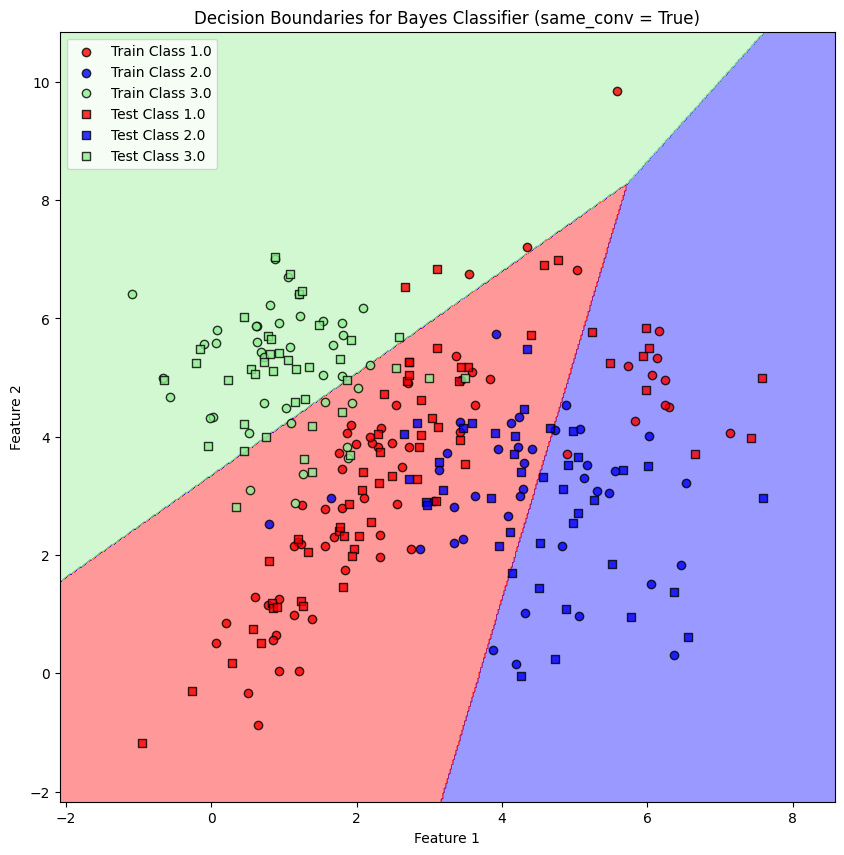

In [ ]:
# Plotting the decision boundaries
plt.figure(figsize=(10, 10))
#plot_decision_boundaries(X_train, y_train, classifier=knn_classifier)
plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier=clf, resolution=0.02)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')
plt.title('Decision Boundaries for Bayes Classifier (same_conv = True)')
plt.show()

The Gaussian Bayes classifier's performance, with a shared covariance matrix, yielded an accuracy of 71.42\% on the test set. The visualization of the decision boundaries indicates a limitation in the classifier's ability to capture more complex patterns, as evidenced by the misclassification of a cluster of class "1" points as class "2". The linear nature of the boundaries suggests that the classifier's assumption of identical variance across classes is too restrictive. It is expected that employing a classifier that assumes distinct covariance matrices for each class could provide better results. This approach would allow for non-linear decision boundaries that are better suited to the data's distribution, leading to improved classification accuracy.


In [ ]:
clf = GaussianBayesClassifier(use_same_cov=False)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f'Accuracy on the test set (diff covariance matrix): {accuracy}')

Accuracy on the test set (diff covariance matrix): 0.85


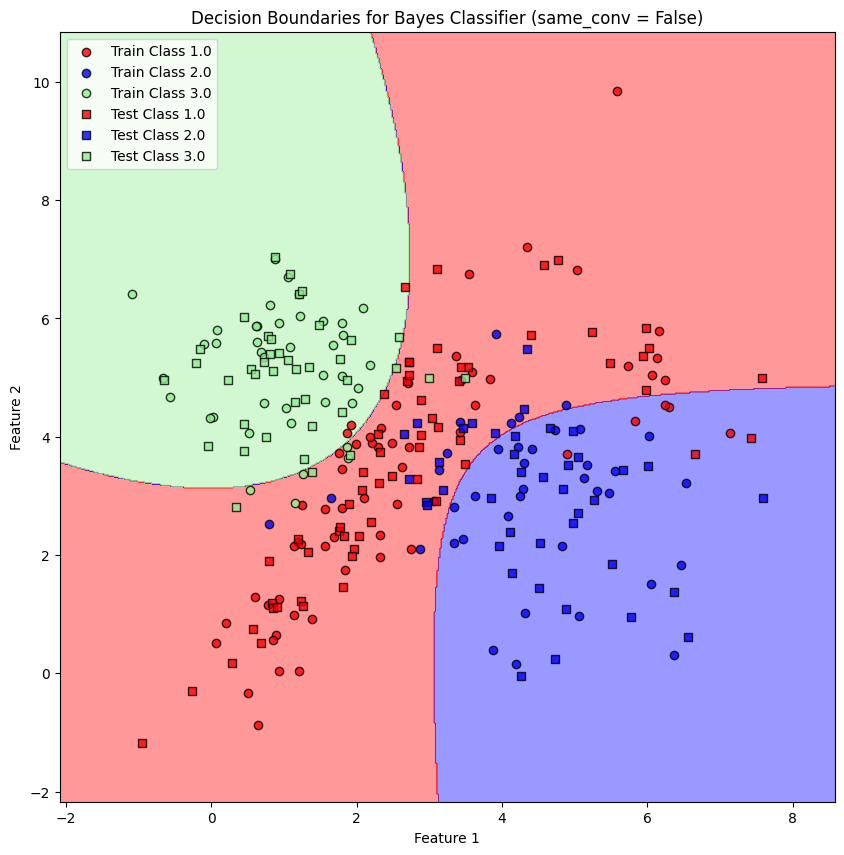

In [ ]:
# Plotting the decision boundaries
plt.figure(figsize=(10, 10))
#plot_decision_boundaries(X_train, y_train, classifier=knn_classifier)
plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier=clf, resolution=0.02)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')
plt.title('Decision Boundaries for Bayes Classifier (same_conv = False)')
plt.show()

When distinct covariance matrices were utilized for each class, the classifier's test set accuracy improved to 85\%, an increase from the 72.42\% achieved with a single shared covariance matrix. This indicates that separate covariance matrices, which account for the specific variance within each class, enhance classification accuracy. The decision boundaries, tailored to each class's unique distribution, lead to fewer misclassifications. This outcome corroborates the premise that a model with greater flexibility in capturing class-specific features tends to outperform a more constrained approach.


# Part B: KNN classifier

In the second part we will use a KNN classifier. Here the implementation of sk learn will be used

In [ ]:
# -*- coding: utf-8 -*-
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = range(1, 11)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print(accuracies)


[0.8857142857142857, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8928571428571429, 0.8785714285714286, 0.8857142857142857, 0.8928571428571429, 0.9, 0.8857142857142857]


In the evaluation of a classification model with varying \( k \) values from 1 to 10, the accuracy scores demonstrated an interesting pattern. The model started with an accuracy of 88.57\% at \( k=1 \), and experienced a slight decrease followed by a plateau at approximately 87.14\% for \( k \) values 2 to 4. A subsequent increase to 89.29\% at \( k=5 \) indicated that a moderate number of neighbors might better capture general patterns. The trend fluctuated slightly but remained high, reaching a peak at 90\% for \( k=9 \), countering the typical expectation that higher \( k \) values might lead to performance degradation due to overgeneralization. Notably, optimal performances were observed at \( k=5 \), \( k=8 \), and \( k=9 \), suggesting that for this particular dataset, a larger \( k \) value might be preferable, perhaps due to a more balanced consideration of neighboring data points.



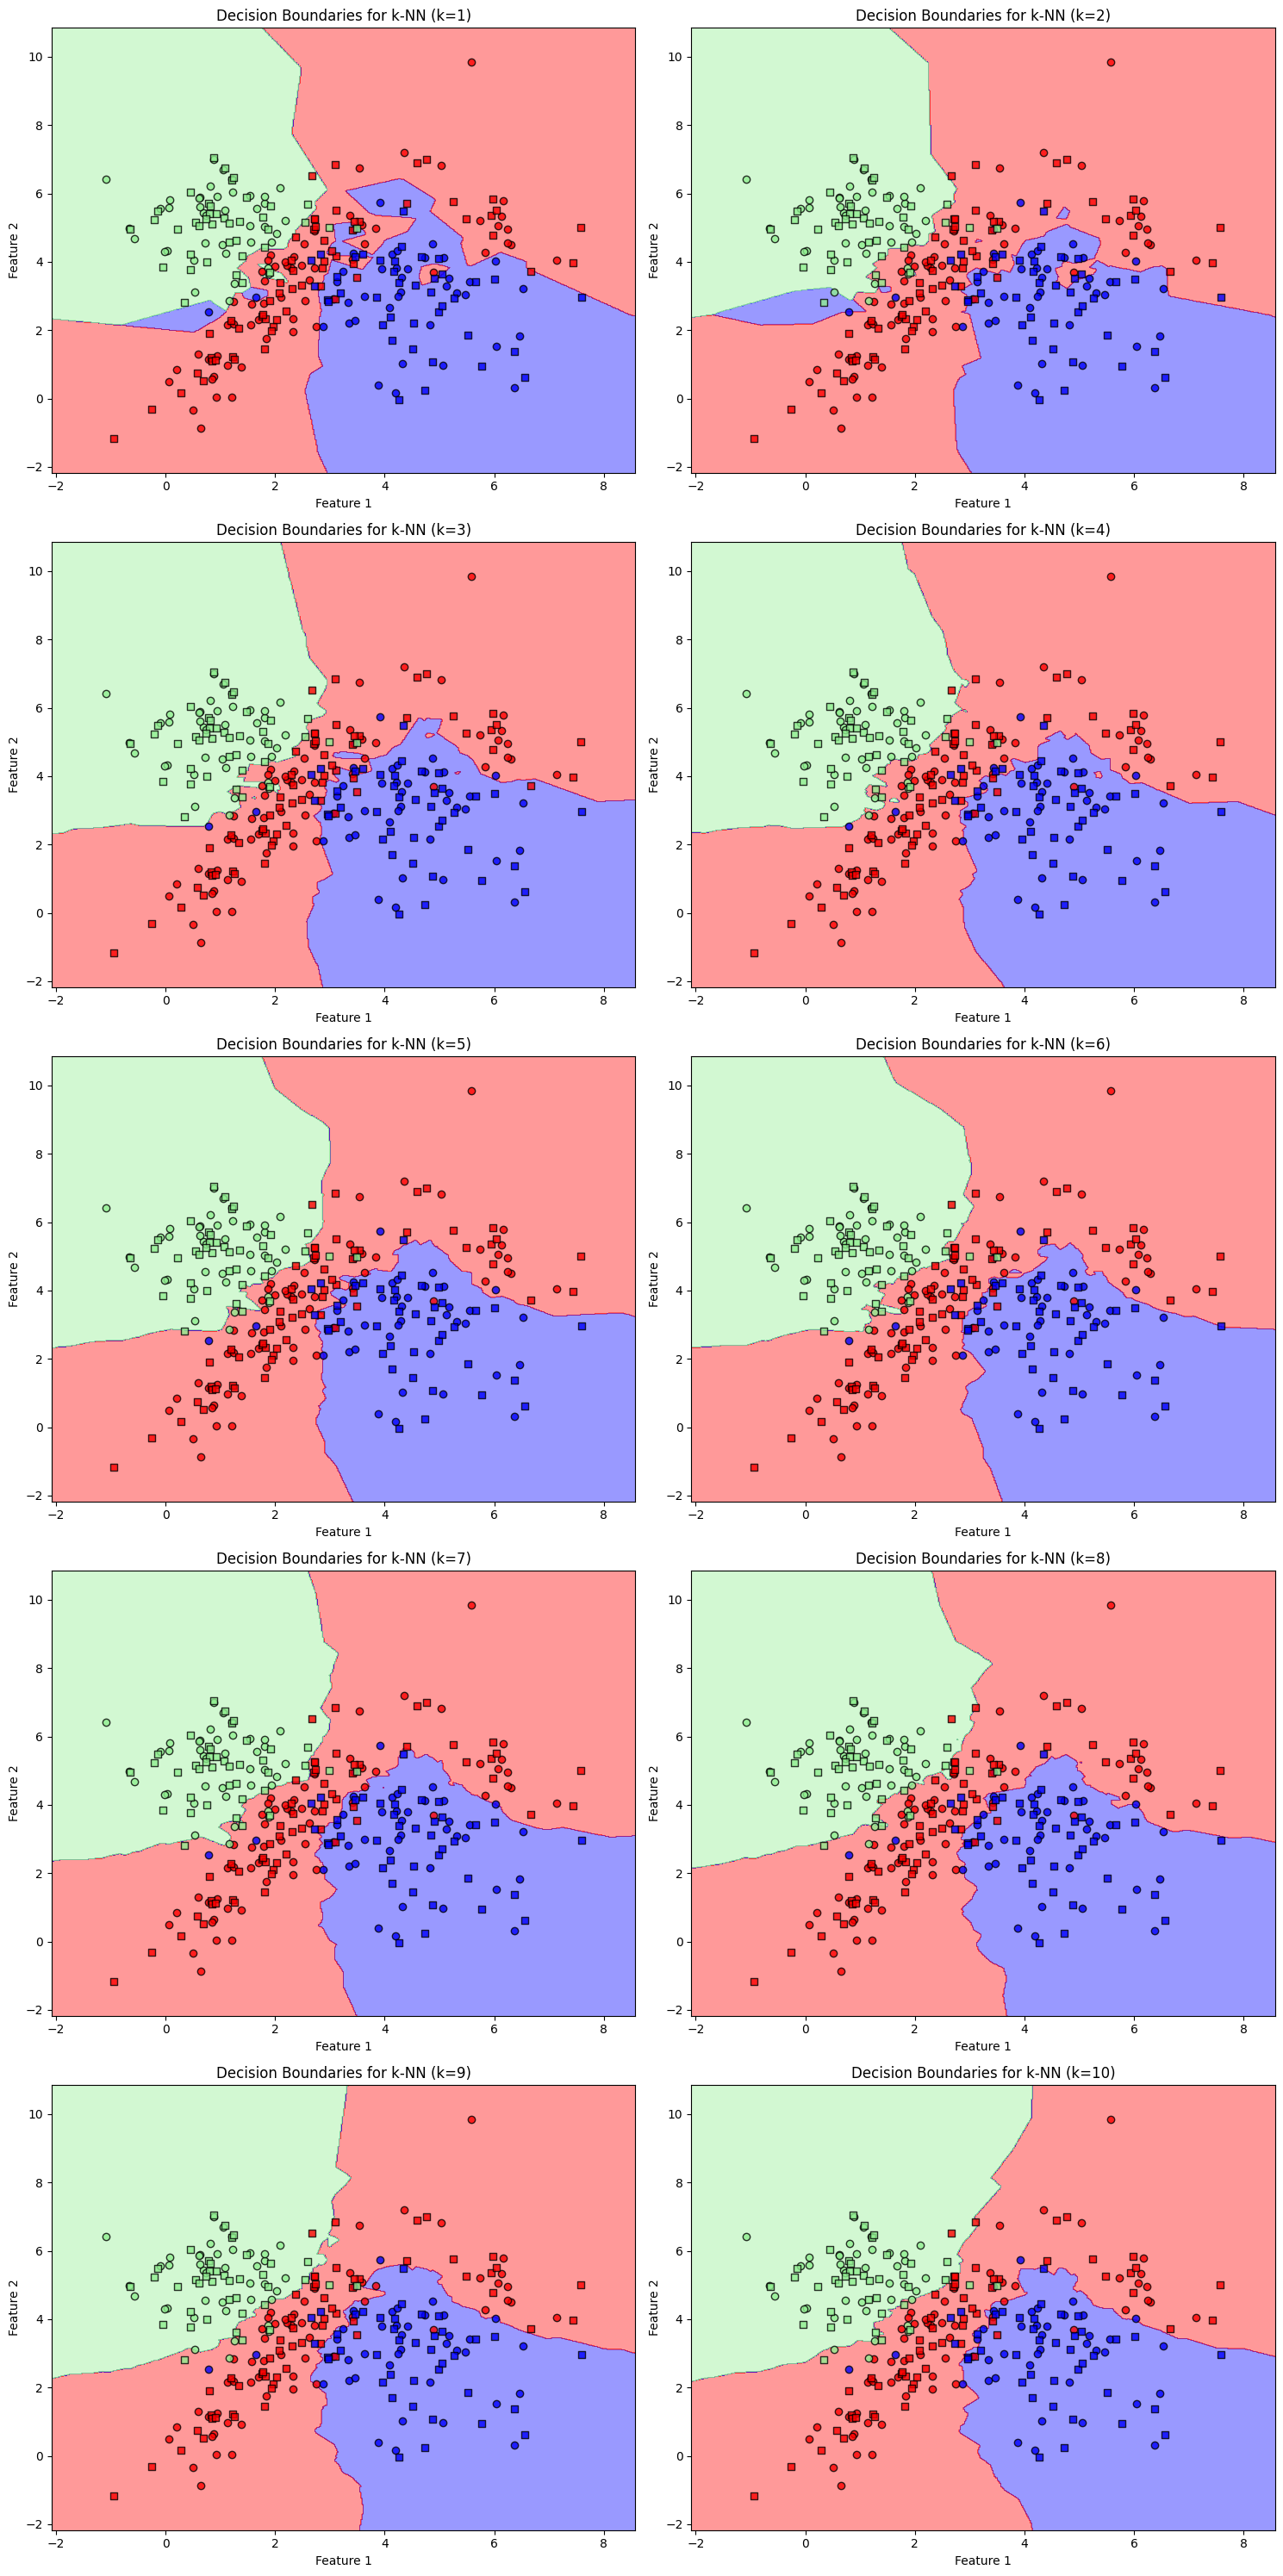

In [ ]:
plt.figure(figsize=(15, 30))

for i, k in enumerate(k_values):
    plt.subplot(5, 2, i + 1)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    #plot_decision_boundaries(X_train, y_train, classifier=knn)
    plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier=knn, resolution=0.02)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Boundaries for k-NN (k={k})')
    plt.tight_layout()

plt.show()

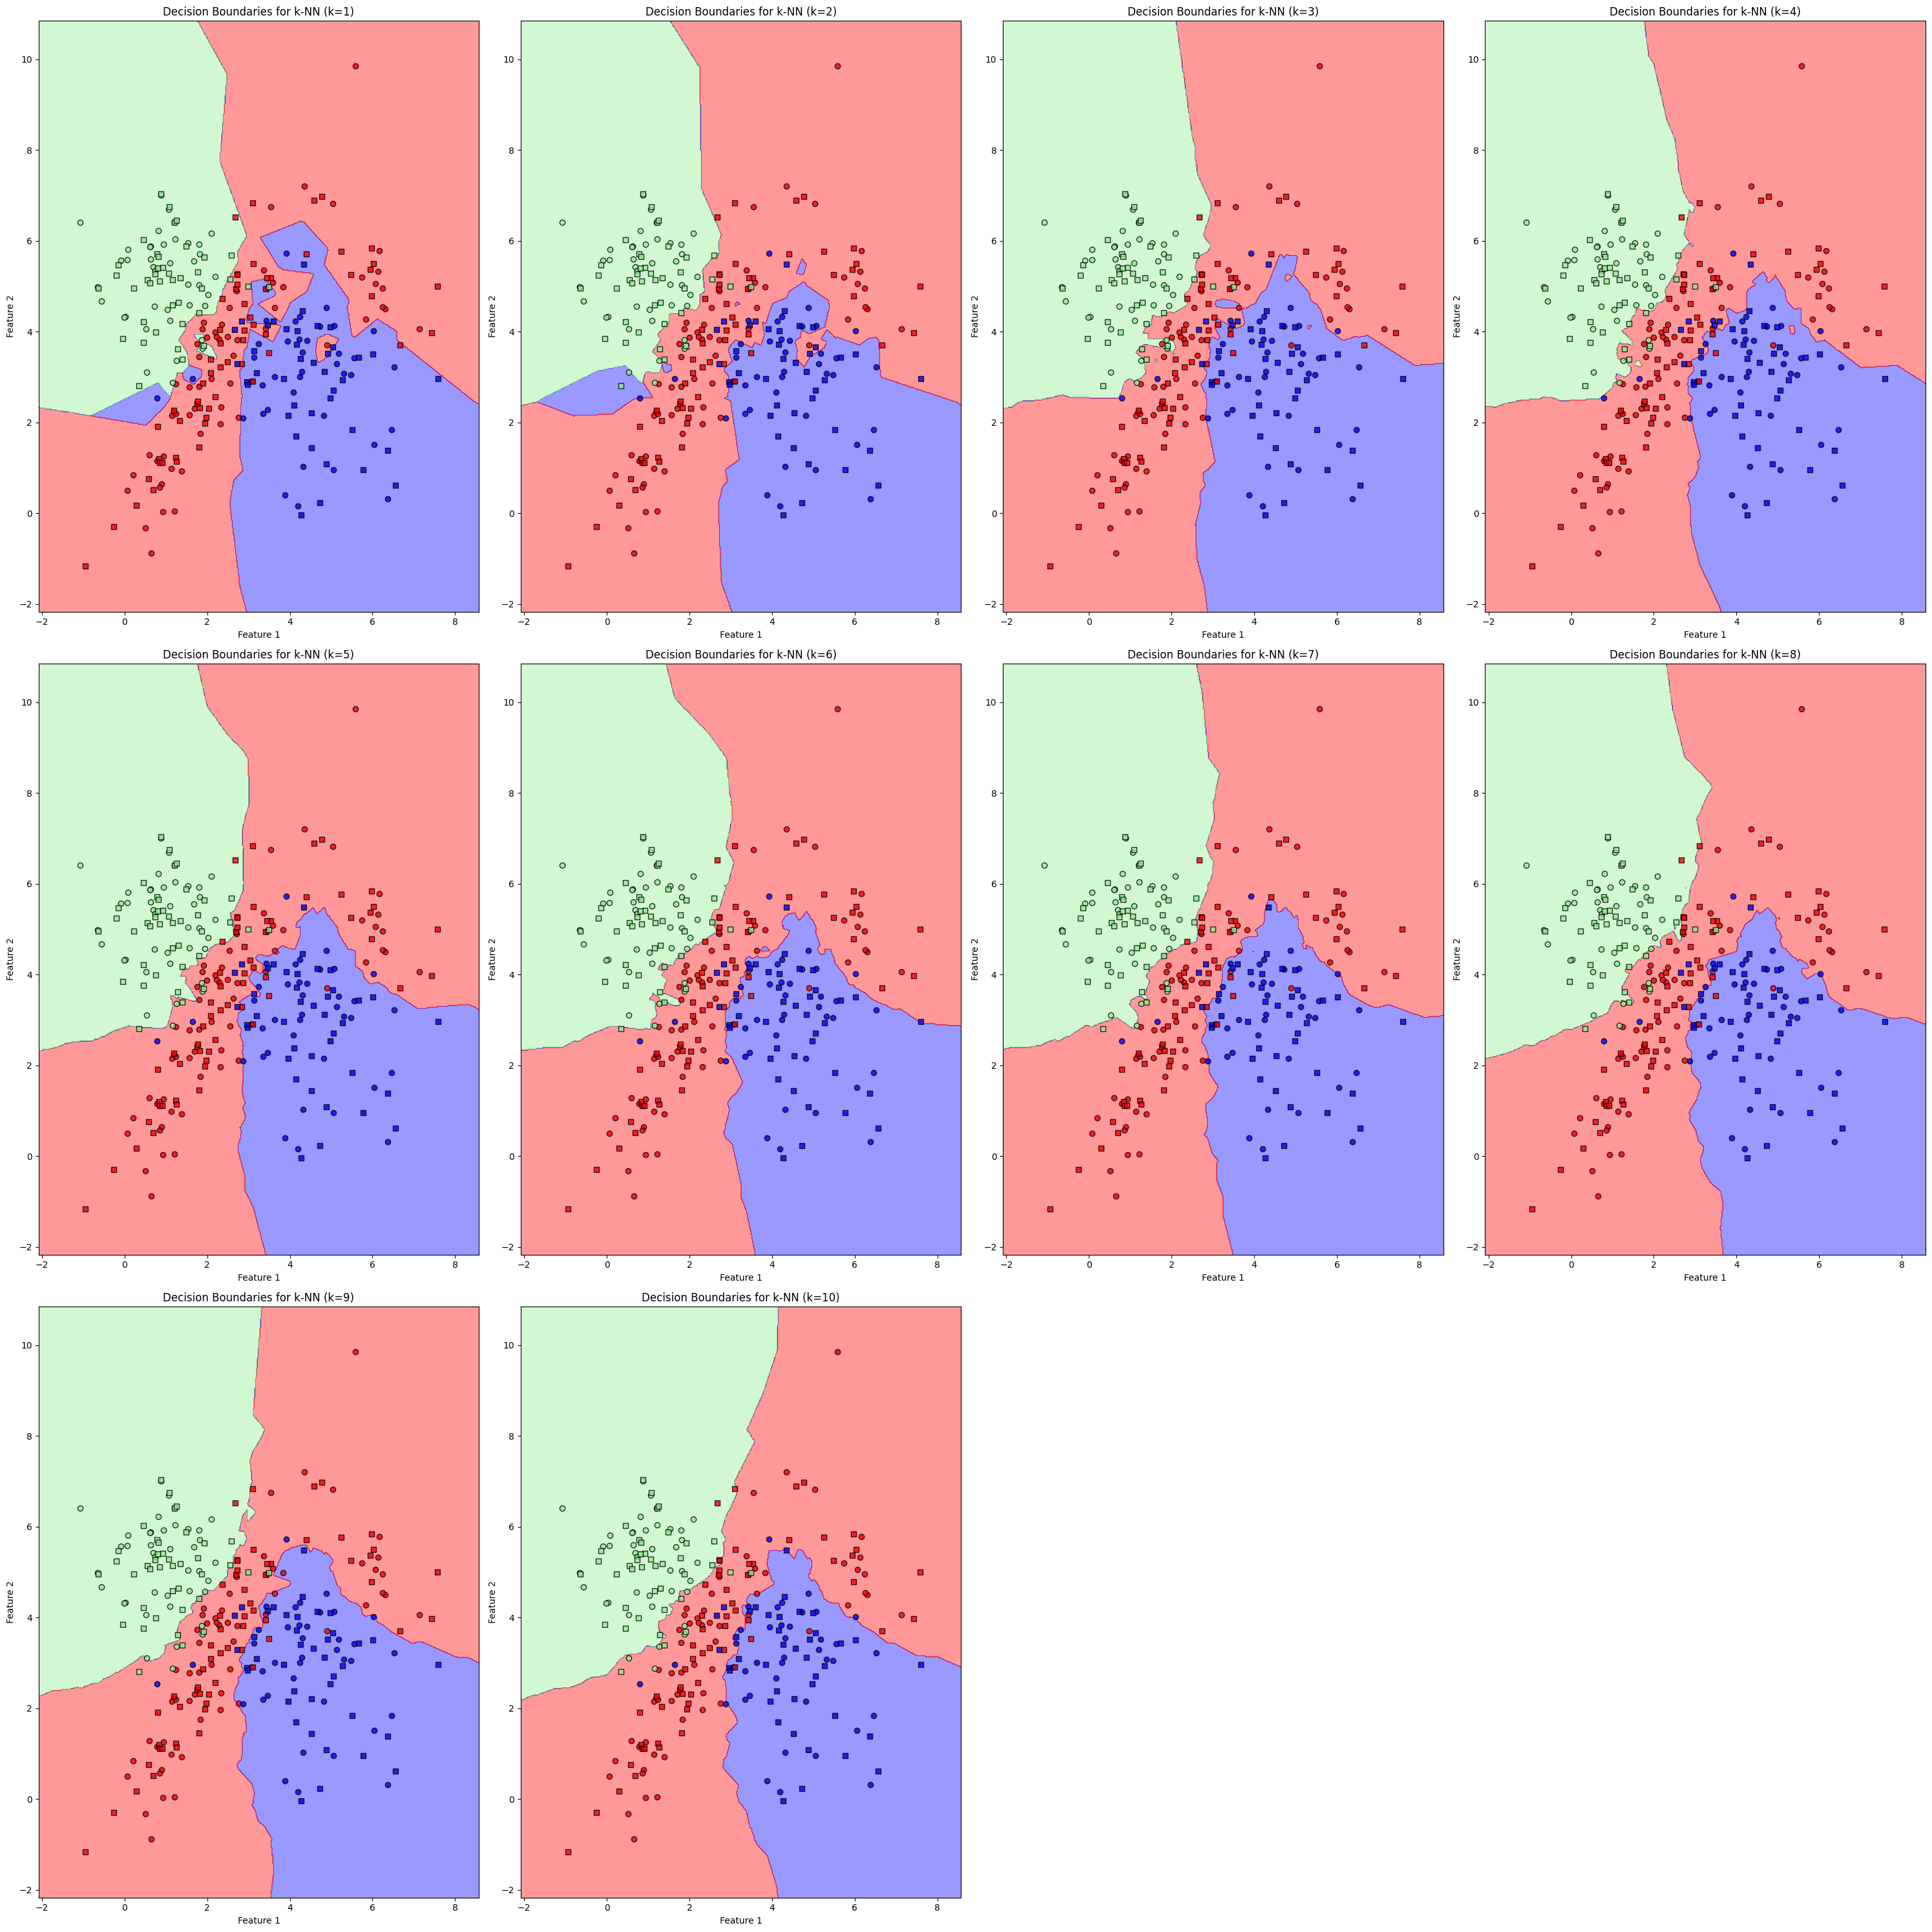

In [ ]:
plt.figure(figsize=(30, 30))

for i, k in enumerate(k_values):
    plt.subplot(3, 4, i + 1)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    #plot_decision_boundaries(X_train, y_train, classifier=knn)
    plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier=knn, resolution=0.02)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Boundaries for k-NN (k={k})')
    plt.tight_layout()

plt.show()

The k-Nearest Neighbors classifier's decision boundary plots with \( k \) values from 1 to 10 demonstrate varying complexity levels in the boundaries. At \( k=1 \), the boundary is highly complex, hinting at overfitting. As \( k \) increases, notably from \( k=3 \) to \( k=5 \), the boundaries become smoother, suggesting the model is generalizing better. For larger \( k \) values, up to \( k=10 \), the boundaries remain smooth yet still effectively separate the different classes, indicating that a higher \( k \) value maintains a good balance between bias and variance without signs of underfitting.



Comparing the accuracy scores, the k-NN classifier's best result (90% for k=9) outperforms the Gaussian Bayes classifier's accuracy of 85% with separate covariance matrices. This suggests that k-NN may be more adept at handling this particular dataset's intricacies without making strong distributional assumptions.

# Part C: SVM classifier

First we will train a linear SVM classifier while using GridSearch to find the optimal values of the regularization parameter 'C'. The 'C' parameter dictates the trade-off between the classifier's simplicity and its performance on the training data. A higher 'C' value can lead to a more complex model by making the cost of misclassifying training examples higher, which may lead to a better fit but can also cause overfitting.

In [ ]:
# -*- coding: utf-8 -*-
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for 'C'
param_grid = {'C': [1e-3, 0.1, 1, 10, 100, 1000]}

# Creating the SVM classifier with a linear kernel
svm_linear = SVC(kernel='linear')

# Performing grid search with cross-validation
grid_search = GridSearchCV(svm_linear, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best 'C' parameter found
best_C = grid_search.best_params_['C']
best_C, grid_search.best_score_


svm_linear_best = SVC(kernel='linear', C=best_C)
svm_linear_best.fit(X_train, y_train)
accuracy_test = svm_linear_best.score(X_test, y_test)

print(f'Best C: {best_C}')
print(f'Accuracy on the test set: {accuracy_test}')


Best C: 100
Accuracy on the test set: 0.8


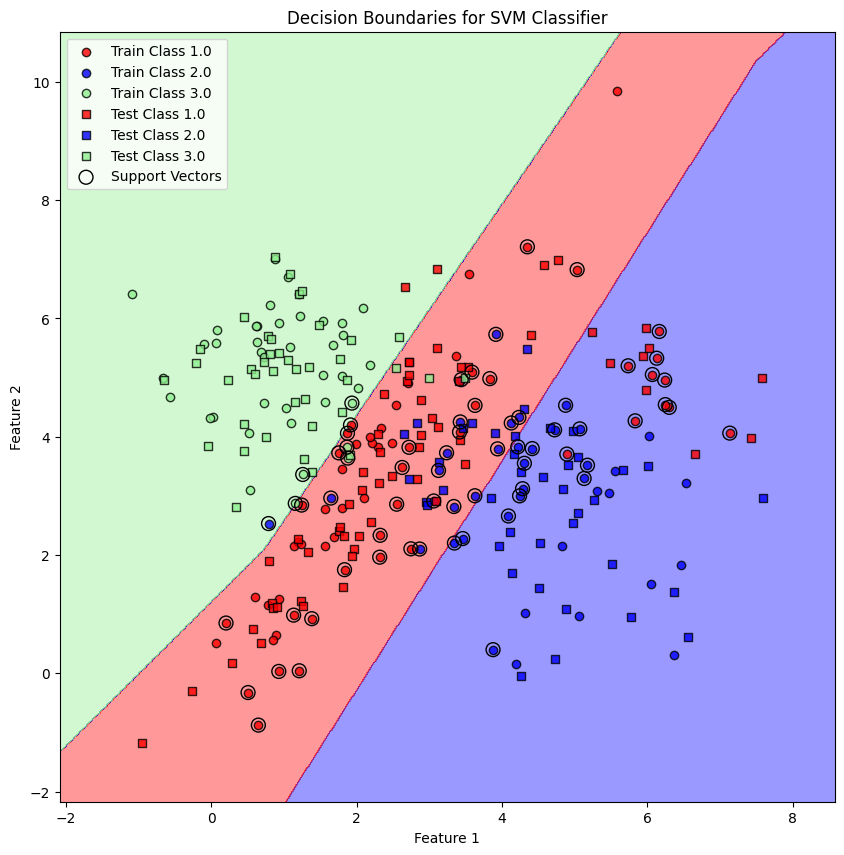

In [ ]:
# Plotting the decision boundaries
plt.figure(figsize=(10, 10))
#plot_decision_boundaries(X_train, y_train, classifier=knn_classifier)
plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier=svm_linear_best, resolution=0.02)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')
plt.title('Decision Boundaries for SVM Classifier')
plt.show()

The Support Vector Machine (SVM) classifier, utilizing a linear kernel and optimized through a grid search for hyperparameter \( C \), achieved an accuracy of 80\% on the test set with the best \( C \) value determined to be 100. Despite the clear separation, the amount of support vectors especially for the class 2 and 3, that are also in the regions of each other and the class overlap that is evident near the boundaries, suggests that the linear model may not capture all underlying data structures although it outperform the Bayes model with same covariance matrix (linear boundary regions). This observation indicates a potential for improved performance with non-linear kernels that could better model the data's complexity.


In the optimization of an SVM with an RBF kernel, a grid search will be performed over the hyperparameters 'C' and 'gamma'. The 'gamma' parameter defines the extent of the influence of a single training example. Higher values of 'gamma' correspond to support vectors with a smaller radius of influence, which can make the decision boundary more irregular, capturing very specific data patterns but potentially leading to overfitting. Conversely, a small 'gamma' value implies a larger radius, resulting in a smoother decision boundary that can generalize better but might underfit the data if it becomes too constrained.

In [ ]:
# Setting up the parameter grid for 'C'
param_grid = {'C': [1e-3, 0.1, 0.5, 1, 1.5, 10, 100],
              'gamma': [0.1, 0.5, 1, 1.5, 10, 10, 'scale', 'auto']}

#scale = 1 / (n_features * X.var())
#auto = 1 / n_features

# Creating the SVM classifier with a linear kernel
svm_rbf = SVC(kernel='rbf')

# Performing grid search with cross-validation
grid_search = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best 'C' parameter found
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
print(f"best score cv: {grid_search.best_score_}")

svm_rbf_best = SVC(kernel='rbf', C=best_C)
svm_rbf_best.fit(X_train, y_train)
accuracy_test = svm_rbf_best.score(X_test, y_test)

print(f'Best C: {best_C}')
print(f'Best gamma: {best_gamma}')
print(f'Accuracy on the test set: {accuracy_test}')

best score cv: 0.9071428571428573
Best C: 1
Best gamma: 0.1
Accuracy on the test set: 0.8857142857142857


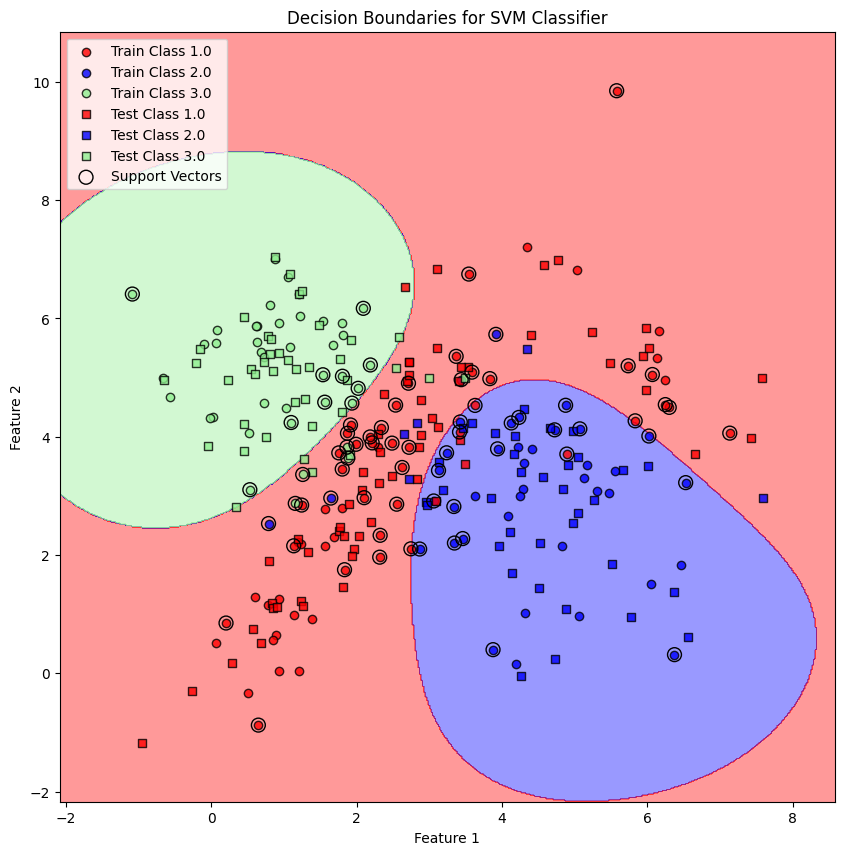

In [ ]:
# Plotting the decision boundaries
plt.figure(figsize=(10, 10))
#plot_decision_boundaries(X_train, y_train, classifier=knn_classifier)
plot_decision_boundaries_modified(X_train, X_test, y_train, y_test, classifier=svm_rbf_best, resolution=0.02)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')
plt.title('Decision Boundaries for SVM Classifier')
plt.show()

The SVM with an RBF kernel achieved a notable test set accuracy of 88.57\%, which surpasses the performance of the linear SVM (80\%), the Gaussian Bayes classifier with a shared covariance matrix (72.42\%), the Gaussian Bayes classifier with separate covariance matrices (85\%), but falls just short to the best k-NN classifier (90\%). The optimal hyperparameters for the RBF SVM were determined to be \( C=1 \) and \( gamma \) set to '0.1', suggesting a model that is well-tuned to the data's complexity without overfitting. This is supported by the decision boundary visualization, showing a balance between capturing the data's intricacies and maintaining generalizability. Also the support vectors seem to be far fewer than the case of the linear model and create decision boudnaries that make more sense to the human eye, capturing more intricate patterns. In contrast to the linear models and simpler classifiers, the RBF kernel SVM's ability to model non-linear relationships contributed to its superior accuracy, making it a compelling choice for datasets with complex class boundaries.
